#### Unsupervised Anomaly Detection


In [301]:
import csv
import datetime
import re
import codecs
import requests
import pandas as pd
import cufflinks as cf #cufflinks binds pandas to plotly for easy plotting
print(cf.__version__)
from plotly.offline import init_notebook_mode, iplot
# libraries
#%matplotlib notebook
import numpy as np
import matplotlib
import seaborn as sns
import matplotlib.dates as md
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
#from pyemma import msm # not available on Kaggle Kernel
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
%matplotlib inline

0.12.1


In [77]:
# some function for later

# return Series of distance between each point and his distance with the closest centroid
def getDistanceByPoint(data, model):
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.set_value(i, np.linalg.norm(Xa-Xb))
    return distance

# train markov model to get transition matrix
def getTransitionMatrix (df):
    df = np.array(df)
    model = msm.estimate_markov_model(df, 1)
    return model.transition_matrix

def markovAnomaly(df, windows_size, threshold):
    transition_matrix = getTransitionMatrix(df)
    real_threshold = threshold**windows_size
    df_anomaly = []
    for j in range(0, len(df)):
        if (j < windows_size):
            df_anomaly.append(0)
        else:
            sequence = df[j-windows_size:j]
            sequence = sequence.reset_index(drop=True)
            df_anomaly.append(anomalyElement(sequence, real_threshold, transition_matrix))
    return df_anomaly

The data is available on the kaggle website [here](https://www.kaggle.com/boltzmannbrain/nab/data). This is data for which we know the anomaly causes; no hand labeling. Included is data of machine sensors, taxi demand, and others.

In [311]:
df=pd.read_csv("/Users/nanaakwasiabayieboateng/Documents/memphisclassesbooks/DataMiningscience/Anomalydetection/realKnownCause/ambient_temperature_system_failure.csv")
df.head()

timestamp      value
0  7/4/13 0:00  69.880835
1  7/4/13 1:00  71.220227
2  7/4/13 2:00  70.877805
3  7/4/13 3:00  68.959400
4  7/4/13 4:00  69.283551

#### Understand the Data

In [21]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 2 columns):
timestamp    7267 non-null object
value        7267 non-null float64
dtypes: float64(1), object(1)
memory usage: 113.6+ KB
None


In [46]:
type(df)


pandas.core.frame.DataFrame

In [84]:
# Get summary of data
df.describe(3)

value
count  7267.000000
mean     71.242433
std       4.247509
min      57.458406
25%      68.369411
50%      71.858493
75%      74.430958
max      86.223213

In [103]:
df.dtypes

timestamp     object
value        float64
dtype: object

In [556]:
#Viridis colors

'''
"#470E61FF" "#481B6DFF" "#482576FF" "#46307EFF"
 [6] "#443B84FF" "#404688FF" "#3C508BFF" "#38598CFF" "#33628DFF"
[11] "#2F6B8EFF" "#2C738EFF" "#287C8EFF" "#25838EFF" "#228C8DFF"
[16] "#1F948CFF" "#1E9D89FF" "#20A486FF" "#26AD81FF" "#31B57BFF"
[21] "#3FBC73FF" "#4FC46AFF" "#61CB5FFF" "#75D054FF" "#8BD646FF"
[26] "#A2DA37FF" "#B9DE28FF" "#D1E11CFF" "#E8E419FF" "#FDE725FF"

'''

'\n"#470E61FF" "#481B6DFF" "#482576FF" "#46307EFF"\n [6] "#443B84FF" "#404688FF" "#3C508BFF" "#38598CFF" "#33628DFF"\n[11] "#2F6B8EFF" "#2C738EFF" "#287C8EFF" "#25838EFF" "#228C8DFF"\n[16] "#1F948CFF" "#1E9D89FF" "#20A486FF" "#26AD81FF" "#31B57BFF"\n[21] "#3FBC73FF" "#4FC46AFF" "#61CB5FFF" "#75D054FF" "#8BD646FF"\n[26] "#A2DA37FF" "#B9DE28FF" "#D1E11CFF" "#E8E419FF" "#FDE725FF"\n\n'

In [312]:
#Convert df['timestamp'] from string to datetime


from datetime import datetime
from dateutil.parser import parse

# change the type of timestamp column for plotting
df['timestamp'] = pd.to_datetime(df['timestamp'])




In [62]:
df.columns.tolist()

['timestamp', 'value']

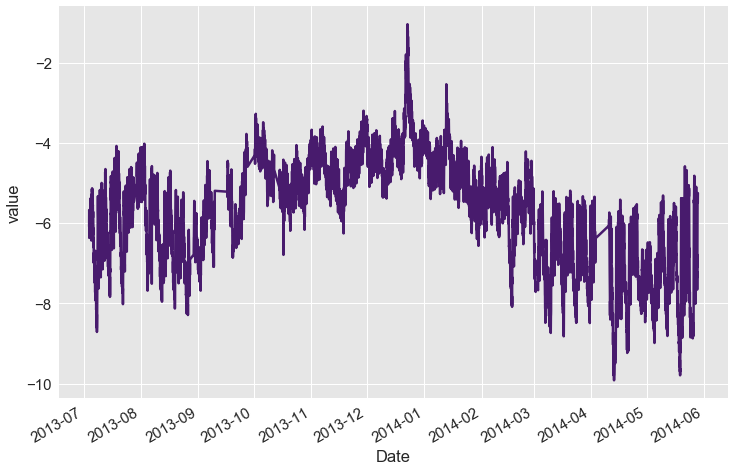

In [410]:
%matplotlib inline
# change the type of timestamp column for plotting
df['timestamp'] = pd.to_datetime(df['timestamp'])
# change fahrenheit to °C (temperature mean= 71 -> fahrenheit)
df['value'] = (df['value'] - 32) * 5/9
# plot the data
df.plot(x='timestamp', y='value',color="#481B6DFF",legend=None, figsize=(12, 8))
plt.ylabel('value')
plt.xlabel('Date')
plt.show()

In [101]:
# initialize notebook mode
init_notebook_mode(connected=True)
#type below in terminal before starting jupiter
# this stops an error message about limit of data that 
# can be read into notebooks
#jupyter notebook --NotebookApp.iopub_data_rate_limit=10000000000
# set to offline

cf.go_offline()


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


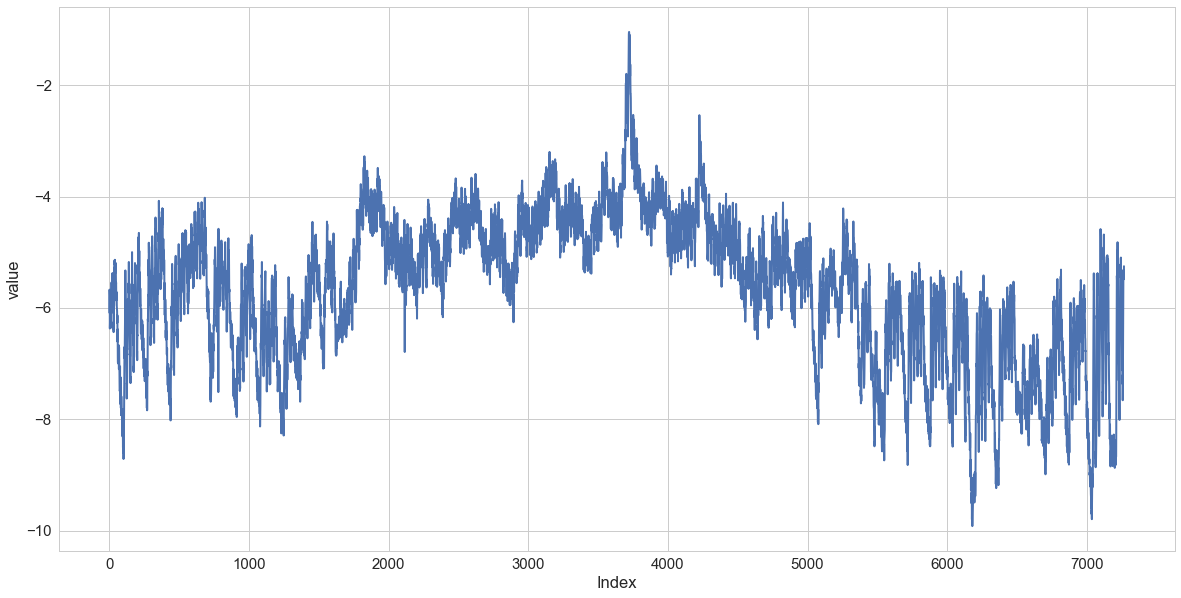

In [442]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1,figsize=(20,10))
plt.plot(df["value"], linewidth=2.0)
plt.ylabel('value')
plt.xlabel('Index')
plt.figure(figsize=(20,10))
plt.show()

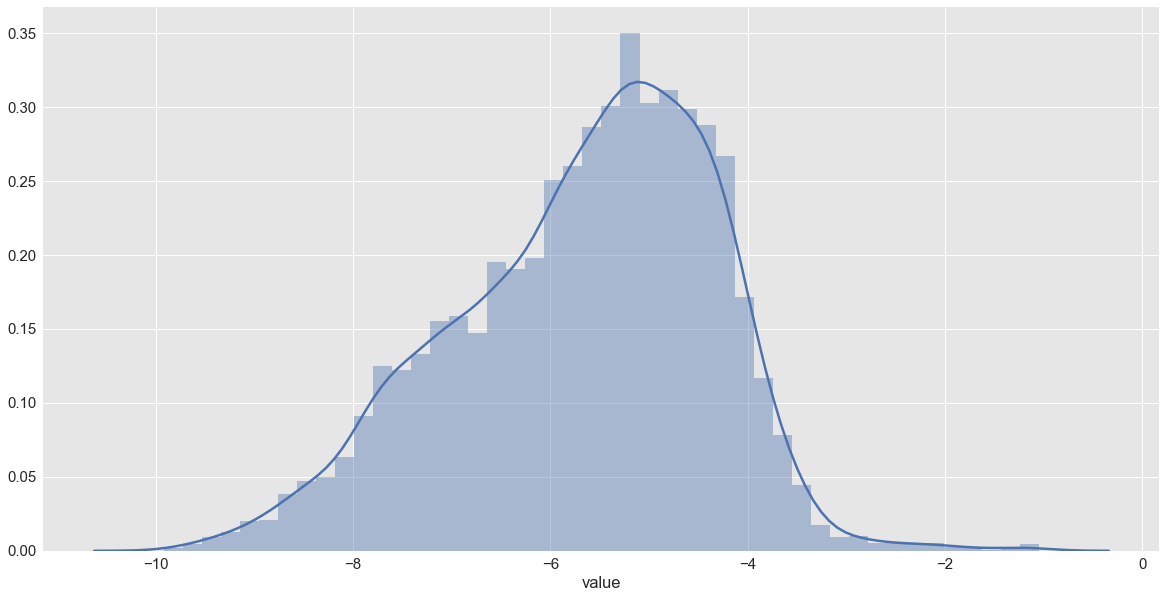

In [441]:
#%matplotlib inline  
#df["value"].hist(bins=100)
#df["value"].plot(kind='density')
fig, ax = plt.subplots(1, 1,figsize=(20,10))
sns.set_style("whitegrid")
sns.distplot(df["value"], hist=True)
#suppresses message
plt.show()

In [122]:
import plotly.plotly as py
import plotly.figure_factory as ff

import numpy as np

colors = [ 'rgb(0, 0, 100)','rgb(0, 200, 200)']
colors = ['#A56CC1', '#A6ACEC', '#63F5EF','#3A4750', '#F64E8B']

hist_data = [df["value"]]
group_labels = ['distplot']

fig = ff.create_distplot(hist_data, group_labels, bin_size=.05, colors=colors, show_hist=True)
fig['layout'].update(title='Temperature Distribution plot')
plotly.offline.iplot(fig, filename=' Distplot')

In [94]:
from datetime import datetime
from dateutil.parser import parse
#datetime.strptime(df["timestamp"],"%m/%d/%y")

df["timestamp"].dtypes

dtype('O')

In [304]:
import plotly
from plotly.graph_objs import Scatter, Layout

plotly.offline.init_notebook_mode(connected=True)




plotly.offline.iplot({
    "data": [Scatter(x=df["timestamp"],  y=df['value'])],
    
    'layout': {'title': 'Temperature', 
    'xaxis' : dict(title='Time'), 
     'yaxis' : dict(title='Degree Celsius'),
            
               
                          'font': dict(size=16)}
    
              })


#### Algorithm implemented :
* Cluster based anomaly detection (K-mean)
* Repartition of data into categories then Gaussian/Elliptic Enveloppe on each categories separately
* Markov Chain
* Isolation Forest
* One class SVM
* RNN (comparison between prediction and reality)

#### Feature engineering
Creatung and Extracting some useful features

In [421]:
# the hours and if it's night or day (7:00-22:00)
df['hours'] = df['timestamp'].dt.hour
df['daylight'] = ((df['hours'] >= 7) & (df['hours'] <= 22)).astype(int)

In [422]:
# the day of the week (Monday=0, Sunday=6) and if it's a week end day or week day.
df['DayOfTheWeek'] = df['timestamp'].dt.dayofweek
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)
# An estimation of anomly population of the dataset (necessary for several algorithm)
outliers_fraction = 0.01

In [423]:
# time with int to plot easily
df['time_epoch'] = (df['timestamp'].astype(np.int64)/100000000000).astype(np.int64)


In [424]:
df['year']=df['timestamp'].dt.year
df['week']=df['timestamp'].dt.week
df['quarter']=df['timestamp'].dt.quarter
df['month'] =df['timestamp'].dt.month

In [425]:
# creation of 4 distinct categories that seem useful (week end/day week & night/day)
df['categories'] = df['WeekDay']*2 + df['daylight']

a = df.loc[df['categories'] == 0, 'value']
b = df.loc[df['categories'] == 1, 'value']
c = df.loc[df['categories'] == 2, 'value']
d = df.loc[df['categories'] == 3, 'value']

In [426]:
df['categories'].value_counts()

3    3502
2    1741
1    1344
0     680
Name: categories, dtype: int64

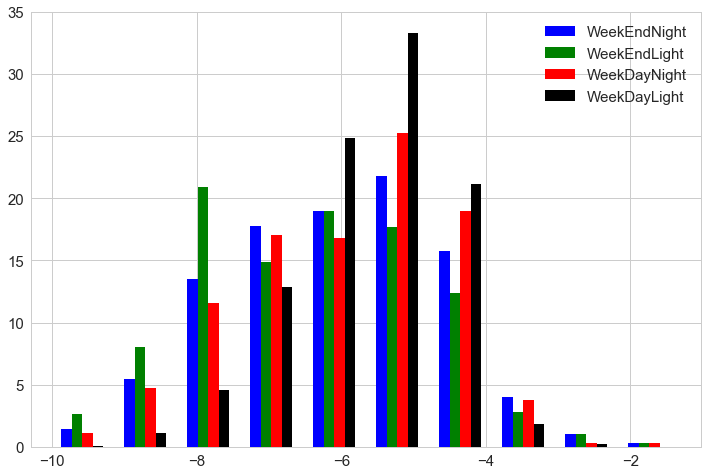

In [427]:
fig, ax = plt.subplots( figsize=(12, 8))
a_heights, a_bins = np.histogram(a)
b_heights, b_bins = np.histogram(b, bins=a_bins)
c_heights, c_bins = np.histogram(c, bins=a_bins)
d_heights, d_bins = np.histogram(d, bins=a_bins)

width = (a_bins[1] - a_bins[0])/6

ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width, facecolor='blue', label='WeekEndNight')
ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width, facecolor='green', label ='WeekEndLight')
ax.bar(c_bins[:-1]+width*2, (c_heights*100/c.count()), width=width, facecolor='red', label ='WeekDayNight')
ax.bar(d_bins[:-1]+width*3, (d_heights*100/d.count()), width=width, facecolor='black', label ='WeekDayLight')

plt.legend()
plt.show()


#### 2 Models
##### 2.1 Cluster only
Use for collective anomalies (unordered).
We group together the usual combination of features. The points that are far from the cluster are points with usual combination of features.We consider those points as anomalies.

In [144]:
a_bins[:-1]

array([-34.82185488, -34.67245493, -34.52305498, -34.37365503,
       -34.22425508, -34.07485513, -33.92545517, -33.77605522,
       -33.62665527, -33.47725532])

In [325]:
# Take useful feature and standardize them
#data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay','quarter','month' ]]
data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# reduce to 2 importants features
pca = PCA(n_components=2)
data = pca.fit_transform(data)
# standardize these 2 new features
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)


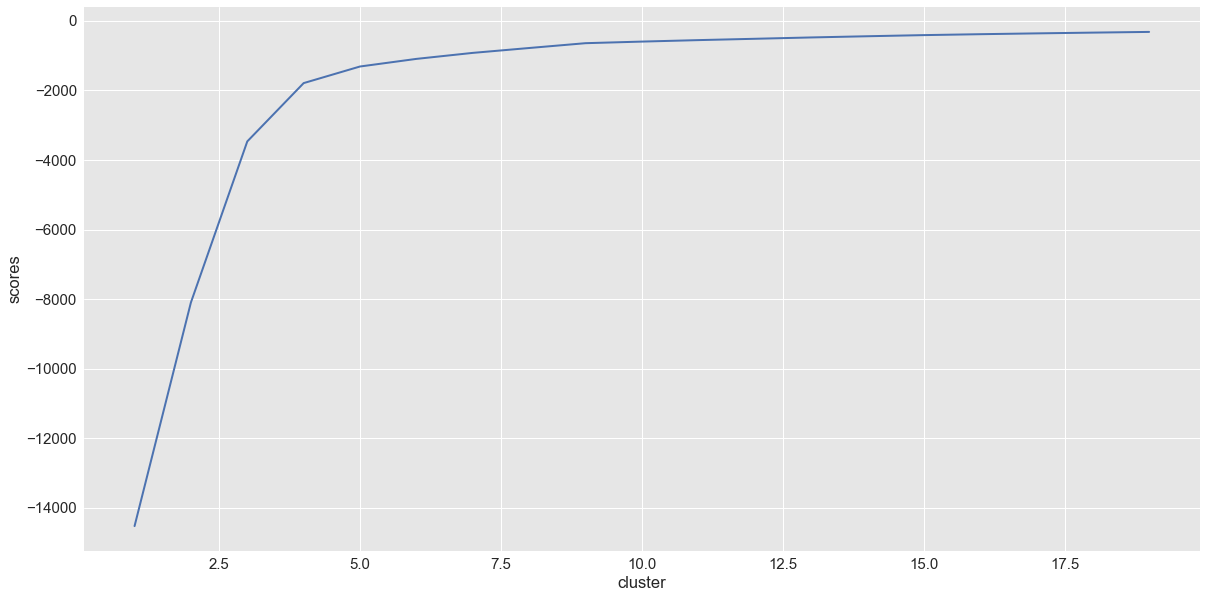

In [440]:
# calculate with different number of centroids to see the loss plot (elbow method)
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]
#fig, ax = plt.subplots()
#ax.plot(n_cluster, scores)
#plt.show()


#plt.plot(n_cluster, scores)

#sns.set_style("whitegrid")
#sns.set()
fig, ax = plt.subplots(1, 1,figsize=(20,10))
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.plot(n_cluster, scores, linewidth=2.0)
plt.ylabel('scores')
plt.xlabel('cluster')
plt.figure(figsize=(20,10))
plt.show()

The highest score is obtained around 15 clusters and upwards. 15 would be ok to work with. We cam predict the number of data  points in each each cluster. The data here is the reduced 2 principal components.

In [327]:

df['cluster'] = kmeans[14].predict(data)
df['principal_feature1'] = data[0]
df['principal_feature2'] = data[1]
df['cluster'].value_counts()

3     653
7     652
11    648
13    627
8     599
6     579
5     576
0     562
12    432
14    358
9     351
2     347
10    336
1     309
4     238
Name: cluster, dtype: int64

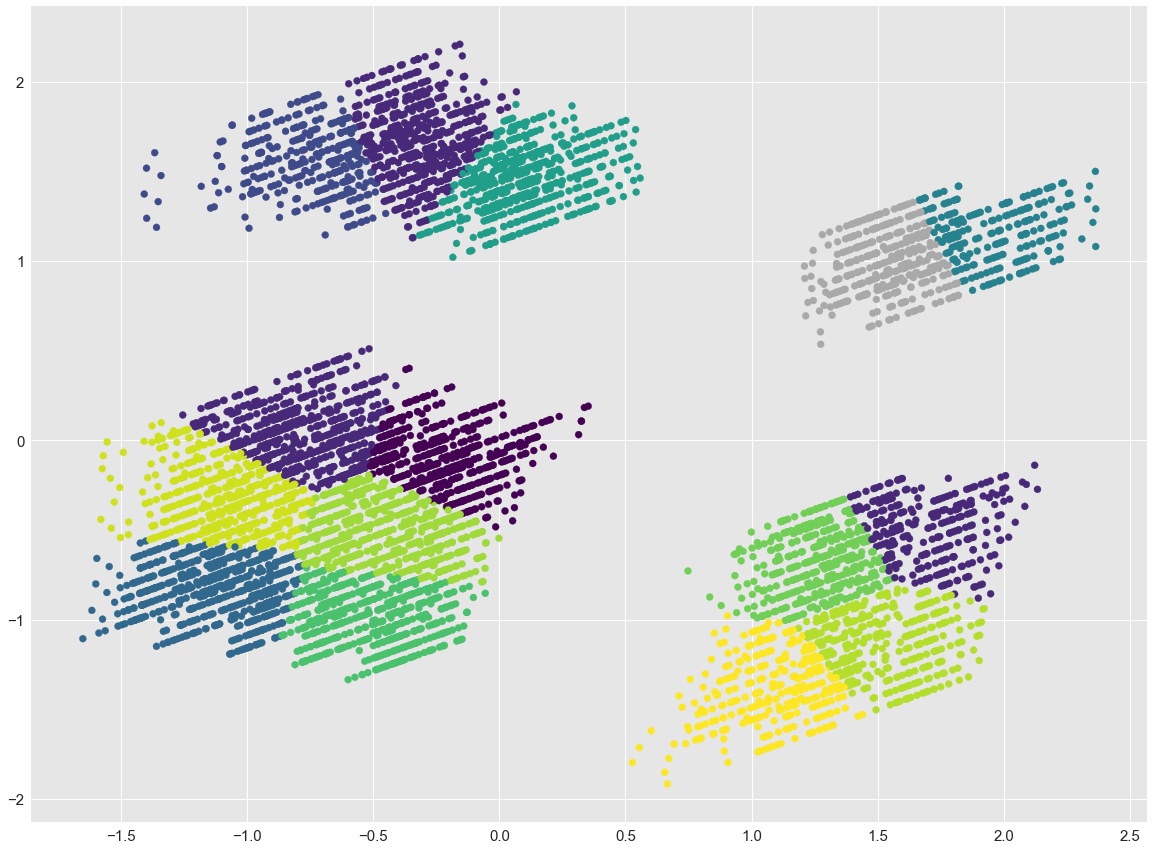

In [434]:
#plot the different clusters with the 2 main features
fig, ax = plt.subplots(figsize=(20,15))
colors = {0:"#440154FF", 1:"#482878FF", 2:"#3E4A89FF", 3:"#31688EFF", 4:"#26828EFF", 5:"#1F9E89FF", 6:"#CFE11CFF", 7:"#482878FF", 8:"#482878FF", 9:"#B4DE2CFF", 10:"#FDE725FF", 11: "#9FDA3AFF", 12:"#71CF57FF", 13:"#4AC16DFF", 14: 'darkgrey'}

#colors={0:'Greys', 1:'Purples', 2:'Blues', 3:'Greens', 4:'Oranges', 5:'Reds',
#            6:'YlOrBr', 7:'YlOrRd', 8:'OrRd', 9:'PuRd', 10:'RdPu', 11:'BuPu',
 #           12:'GnBu', 13:'PuBu', 14:'YlGnBu'}

ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["cluster"].apply(lambda x: colors[x]))
plt.show()

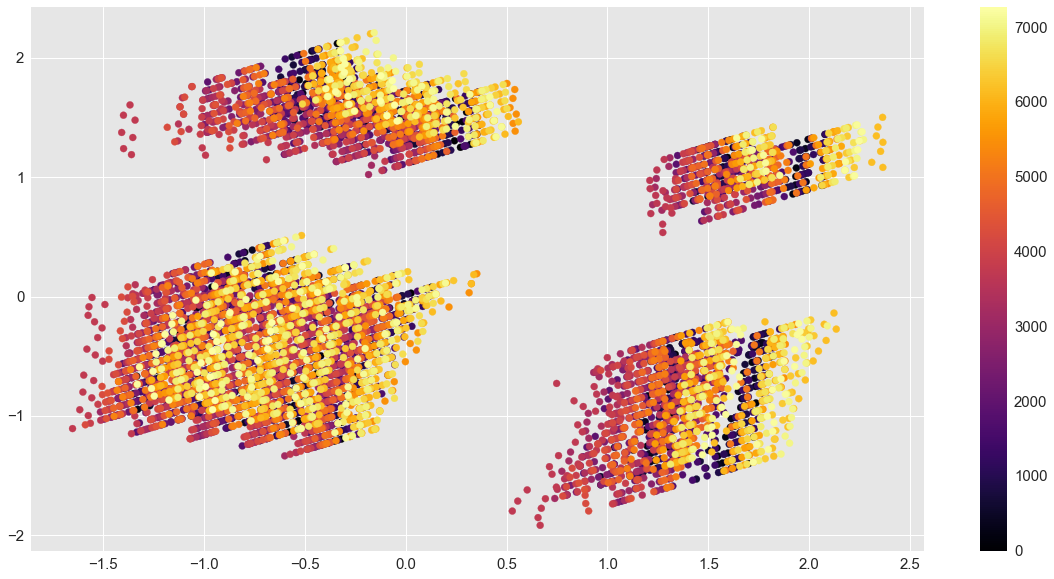

In [439]:
import numpy as np
import matplotlib.pyplot as plt

#x = np.arange(100)
#y = x
#t = x
fig, ax = plt.subplots(1, 1,figsize=(20,10))
#ax1.scatter(x, y, c=t, cmap='viridis')
#ax2.scatter(x, y, c=t, cmap='viridis_r')
#plt.show()
# ['viridis', 'plasma', 'inferno', 'magma']

t=range(df['principal_feature1'].shape[0])
plt.scatter(df['principal_feature1'], df['principal_feature2'], c=t, cmap='inferno')
#plt.figure(figsize=(20,10))
plt.colorbar()
plt.show()

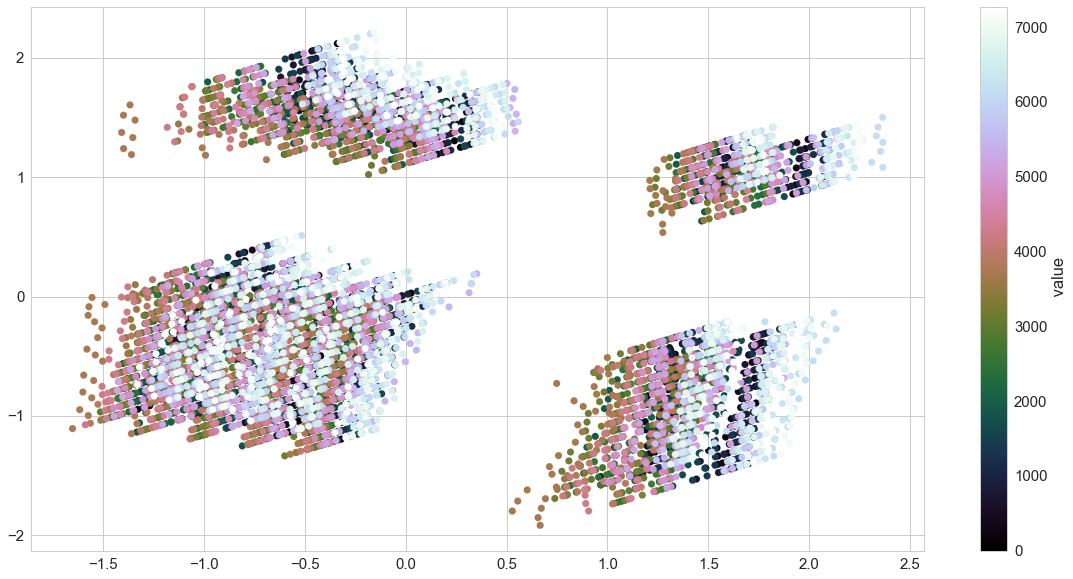

In [443]:

#t=len(df["cluster"].value_counts())

# plot the results

fig, ax = plt.subplots(1, 1,figsize=(20,10))
plt.scatter(df['principal_feature1'], df['principal_feature2'], lw=0.1,
            c=t, cmap=plt.cm.get_cmap('cubehelix',7267 ))
plt.colorbar( label=' value')
#plt.clim(-0.5, 5.5)

In [204]:
len(df["cluster"].value_counts())

#df["cluster"].apply(lambda x: colors[x])

df['principal_feature1'].shape[0]

7267

#### Isomap Embedding
Non-linear dimensionality reduction through Isometric Mapping. Isomap (Isometric Feature Mapping), unlike Principle Component Analysis, is a non-linear feature reduction method.

In [257]:
# load images of the digits 0 through 5 and visualize several of them
#from sklearn.datasets import load_digits
from sklearn.manifold import Isomap
from sklearn import manifold

ddata = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay','quarter','month' ]]

# standardize the new features
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(ddata)
ddata = pd.DataFrame(np_scaled)

# project the features into 2 dimensions using IsoMap
iso = manifold.Isomap(n_neighbors=6, n_components=2)
iso.fit(ddata)
manifold_2Da = iso.transform(ddata)
manifold_2D = pd.DataFrame(manifold_2Da, columns=['principal_feature1', 'principal_feature2'])

# Left with 2 dimensions
manifold_2D.head()

principal_feature1  principal_feature2
0           -0.076857           -0.010182
1           -0.077331           -0.010491
2           -0.077090           -0.010334
3           -0.076062           -0.009665
4           -0.076143           -0.009715

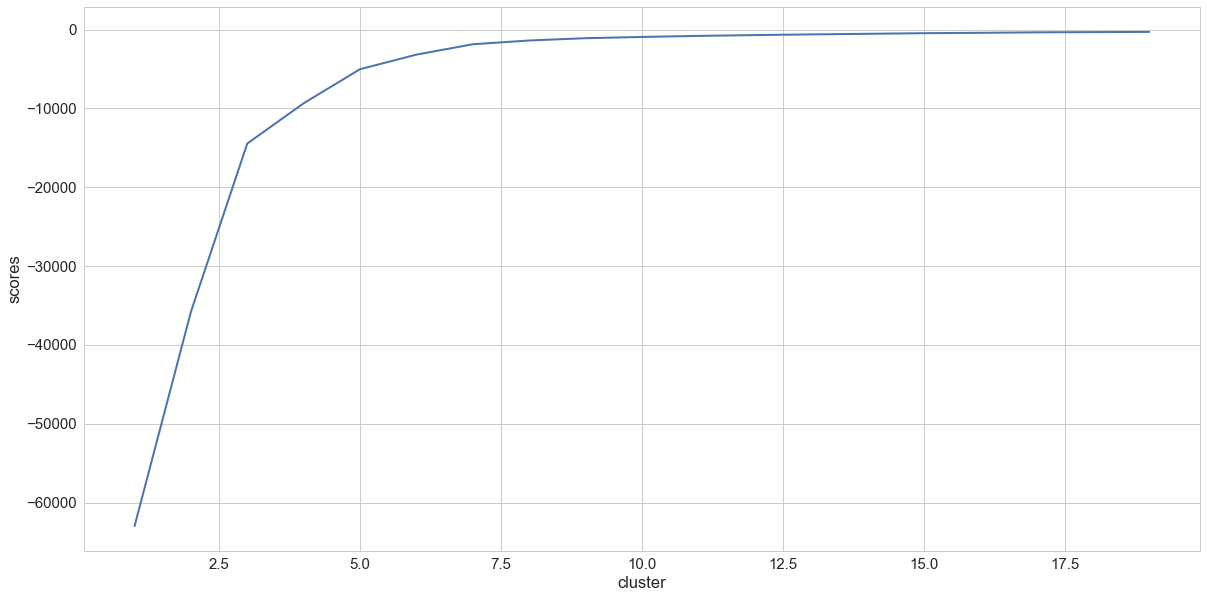

In [444]:
# calculate with different number of centroids to see the loss plot (elbow method)
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(manifold_2D) for i in n_cluster]
scores = [kmeans[i].score(manifold_2D) for i in range(len(kmeans))]
#fig, ax = plt.subplots()
#ax.plot(n_cluster, scores)
#plt.show()


#plt.plot(n_cluster, scores)

#sns.set_style("whitegrid")
#sns.set()
#sns.set_style("darkgrid", {"axes.facecolor": ".9"})

fig, ax = plt.subplots(1, 1,figsize=(20,10))
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.plot(n_cluster, scores, linewidth=2.0)
plt.ylabel('scores')
plt.xlabel('cluster')
plt.show()

using isomap about 10 cluster achieve low scores.

In [259]:
ddata['cluster'] = kmeans[10].predict(manifold_2D)

ddata['principal_feature1'] = manifold_2D['principal_feature1']
ddata['principal_feature2'] = manifold_2D['principal_feature2']
ddata['cluster'].value_counts()


0     5080
3      414
7      255
1      236
10     225
4      217
6      198
2      192
9      169
5      160
8      121
Name: cluster, dtype: int64

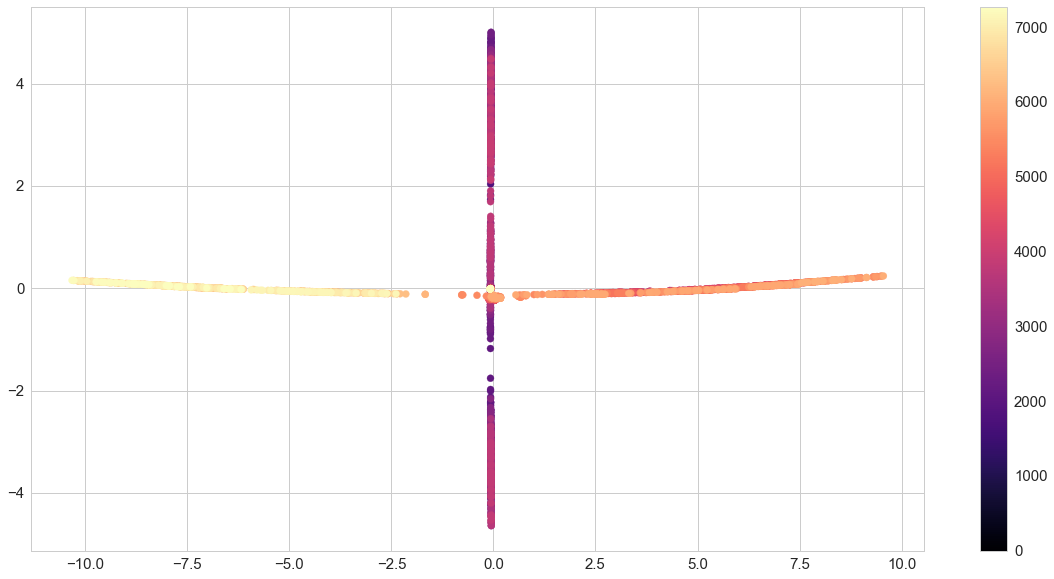

In [445]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1,figsize=(20,10))
t=range(ddata['principal_feature1'].shape[0])
plt.scatter(ddata['principal_feature1'], ddata['principal_feature2'], c=t, cmap='magma')
plt.colorbar()
plt.show()

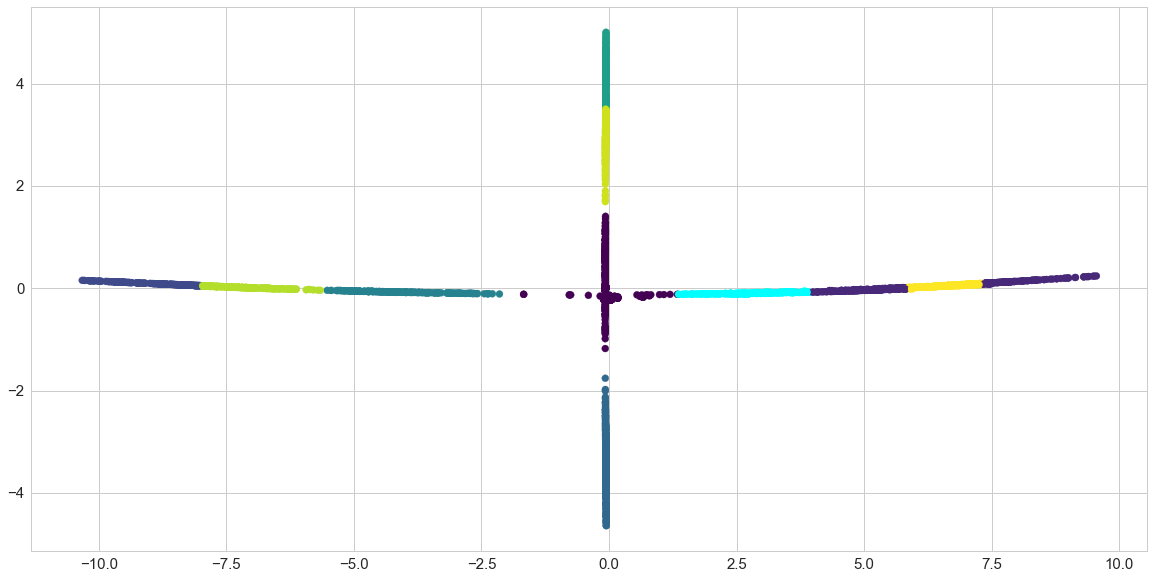

In [446]:
#plot the different clusters with the 2 main features
# viridis  colors for option D
#"#440154FF" "#482878FF" "#3E4A89FF" "#31688EFF" "#26828EFF"
# "#1F9E89FF" "#35B779FF" "#482878FF" "#B4DE2CFF" "#FDE725FF"

fig, ax = plt.subplots(1, 1,figsize=(20,10))
colors = {0:"#440154FF", 1:"#482878FF", 2:"#3E4A89FF", 3:"#31688EFF", 4:"#26828EFF", 5:"#1F9E89FF", 6:"cyan", 7:"#CFE11CFF", 8:"#482878FF", 9:"#B4DE2CFF", 10:"#FDE725FF" }

#colors={0:'Greys', 1:'Purples', 2:'Blues', 3:'Greens', 4:'Oranges', 5:'Reds',
#            6:'YlOrBr', 7:'YlOrRd', 8:'OrRd', 9:'PuRd', 10:'RdPu', 11:'BuPu',
 #           12:'GnBu', 13:'PuBu', 14:'YlGnBu'}

ax.scatter(ddata['principal_feature1'], ddata['principal_feature2'], c=ddata["cluster"].apply(lambda x: colors[x]))
plt.show()

In [399]:
# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = getDistanceByPoint(data, kmeans[14])
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
# anomaly21 contain the anomaly result of method 2.1 Cluster (0:normal, 1:anomaly) 
df['anomaly21'] = (distance >= threshold).astype(int)
df['anomaly21'].value_counts()

/Users/nanaakwasiabayieboateng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning:

set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead



0    7195
1      72
Name: anomaly21, dtype: int64

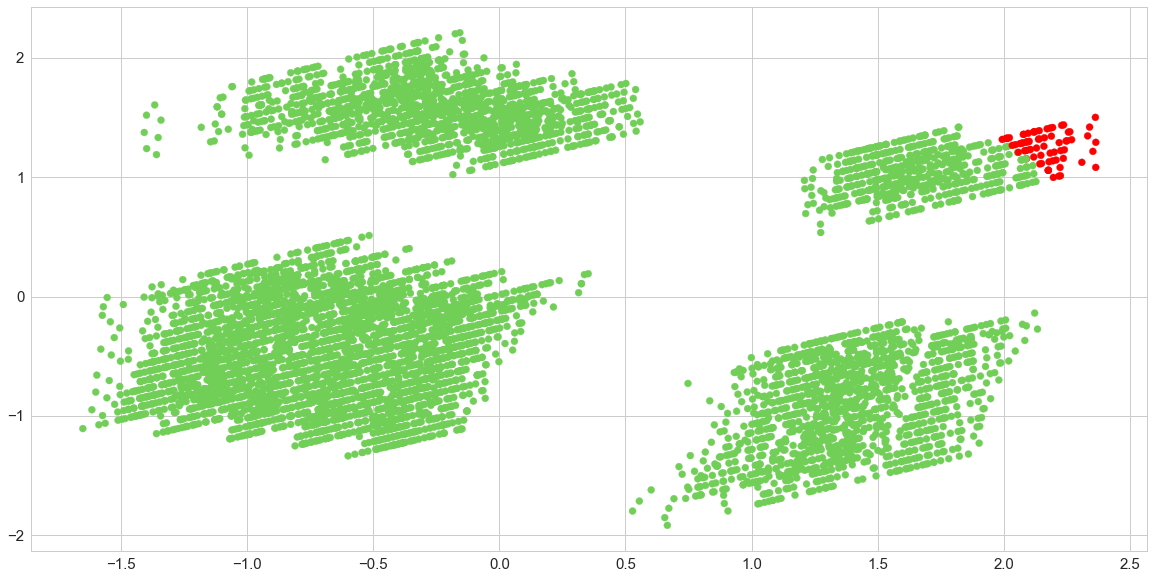

In [447]:
# visualisation of anomaly with cluster view
fig, ax = plt.subplots(1, 1,figsize=(20,10))
colors = {0:"#71CF57FF", 1:"red"}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["anomaly21"].apply(lambda x: colors[x]))
plt.show()

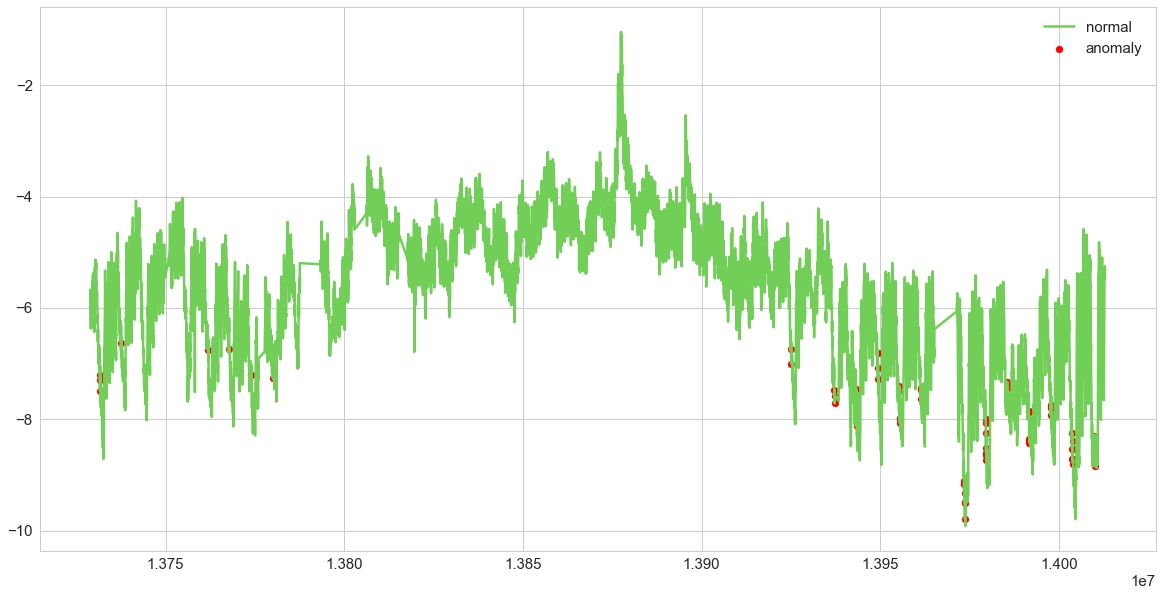

In [473]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots(1, 1,figsize=(20,10))

a = df.loc[df['anomaly21'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color="#71CF57FF", label='normal')
ax.scatter(a['time_epoch'],a['value'], color='red', label= 'anomaly')
plt.legend()
plt.show()

/Users/nanaakwasiabayieboateng/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



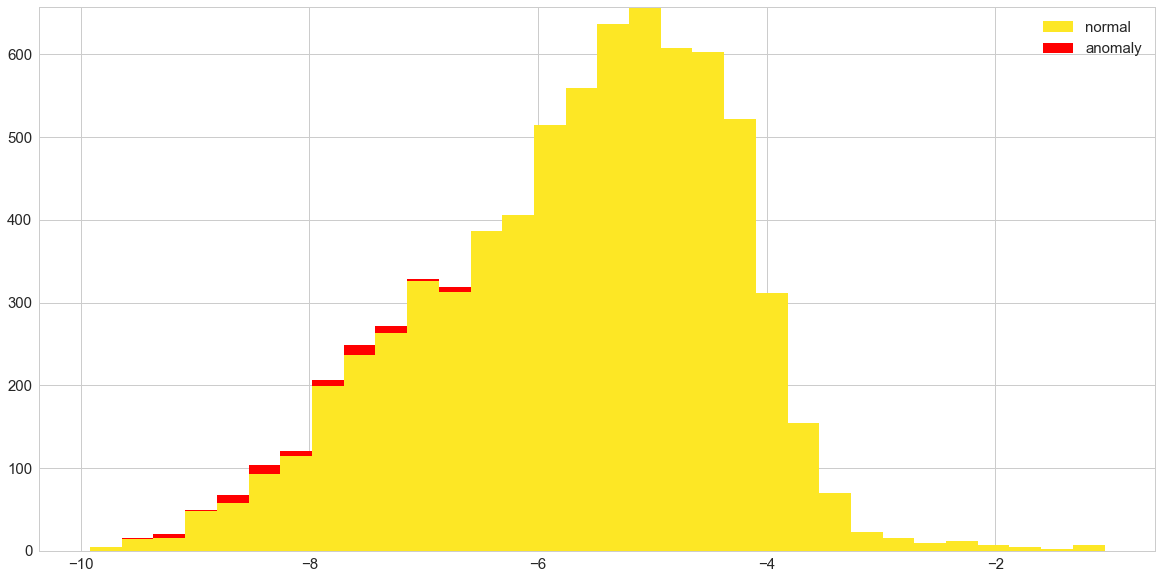

In [450]:
# visualisation of anomaly with temperature repartition (viz 2)
a = df.loc[df['anomaly21'] == 0, 'value']
b = df.loc[df['anomaly21'] == 1, 'value']

fig, axs = plt.subplots(1, 1,figsize=(20,10))
axs.hist([a,b], bins=32, stacked=True, color=["#FDE725FF", 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

Anomalies are detected at lower temperatures between 60 and 75 by the  k-means clustering method

#### Categories + Gaussian
Use for contextual data and collective anomalies (unordered).
We will separate data by (what we think of) important categories. Then we find outliers (gaussian repartition, unimodal) by categories independently.

In [388]:
# creation of 4 differents data set based on categories defined before
df_class0 = df.loc[df['categories'] == 0, 'value']
df_class1 = df.loc[df['categories'] == 1, 'value']
df_class2 = df.loc[df['categories'] == 2, 'value']
df_class3 = df.loc[df['categories'] == 3, 'value']

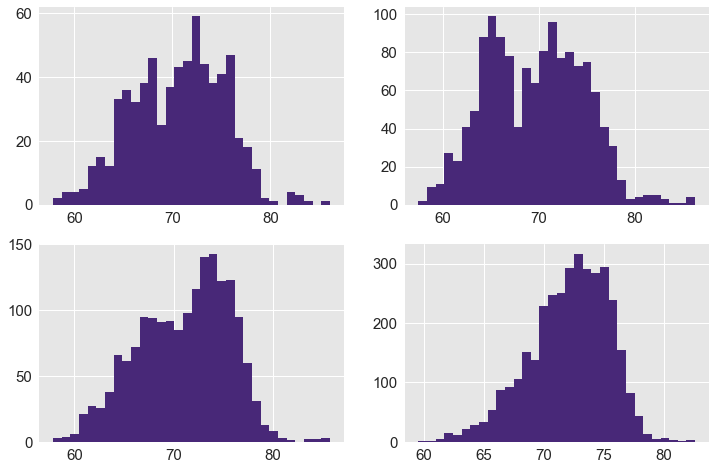

In [390]:
# plot the temperature repartition by categories
fig, axs = plt.subplots(2,2, figsize=(12, 8))
df_class0.hist(ax=axs[0,0],bins=32,color="#482878FF")
df_class1.hist(ax=axs[0,1],bins=32,color="#482878FF")
df_class2.hist(ax=axs[1,0],bins=32,color="#482878FF")
df_class3.hist(ax=axs[1,1],bins=32,color="#482878FF")
plt.show()

In [391]:
# apply ellipticEnvelope(gaussian distribution) at each categories
envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class0.values.reshape(-1,1)
envelope.fit(X_train)
df_class0 = pd.DataFrame(df_class0)
df_class0['deviation'] = envelope.decision_function(X_train)
df_class0['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class1.values.reshape(-1,1)
envelope.fit(X_train)
df_class1 = pd.DataFrame(df_class1)
df_class1['deviation'] = envelope.decision_function(X_train)
df_class1['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class2.values.reshape(-1,1)
envelope.fit(X_train)
df_class2 = pd.DataFrame(df_class2)
df_class2['deviation'] = envelope.decision_function(X_train)
df_class2['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class3.values.reshape(-1,1)
envelope.fit(X_train)
df_class3 = pd.DataFrame(df_class3)
df_class3['deviation'] = envelope.decision_function(X_train)
df_class3['anomaly'] = envelope.predict(X_train)


/Users/nanaakwasiabayieboateng/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



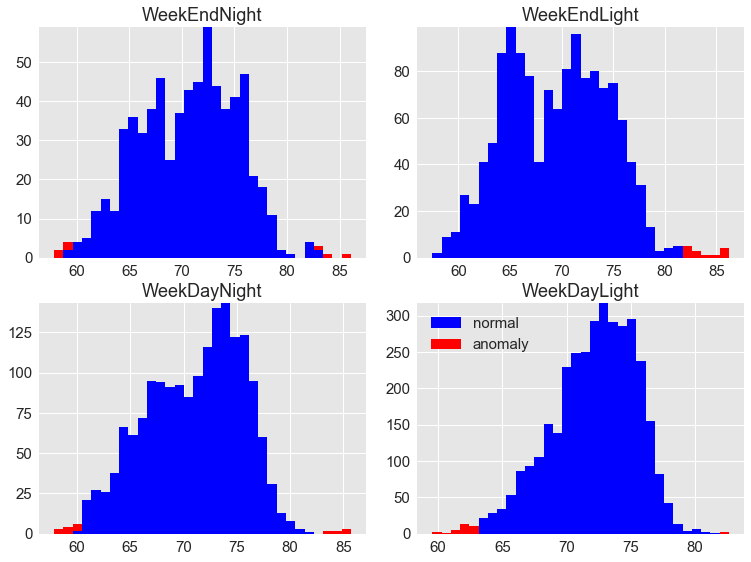

In [369]:
# plot the temperature repartition by categories with anomalies
a0 = df_class0.loc[df_class0['anomaly'] == 1, 'value']
b0 = df_class0.loc[df_class0['anomaly'] == -1, 'value']

a1 = df_class1.loc[df_class1['anomaly'] == 1, 'value']
b1 = df_class1.loc[df_class1['anomaly'] == -1, 'value']

a2 = df_class2.loc[df_class2['anomaly'] == 1, 'value']
b2 = df_class2.loc[df_class2['anomaly'] == -1, 'value']

a3 = df_class3.loc[df_class3['anomaly'] == 1, 'value']
b3 = df_class3.loc[df_class3['anomaly'] == -1, 'value']

fig, axs = plt.subplots(2,2, figsize=(12, 8))
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
#fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
# tight_layout doesn't take these labels into account. We'll need 
# to make some room. These numbers are are manually tweaked. 
# You could automatically calculate them, but it's a pain.
fig.subplots_adjust(left=0.15, top=0.95)
axs[0,0].hist([a0,b0], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[0,1].hist([a1,b1], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[1,0].hist([a2,b2], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[1,1].hist([a3,b3], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[0,0].set_title("WeekEndNight")
axs[0,1].set_title("WeekEndLight")
axs[1,0].set_title("WeekDayNight")
axs[1,1].set_title("WeekDayLight")
plt.legend()
plt.show()

In [458]:
# add the data to the main 
df_class = pd.concat([df_class0, df_class1, df_class2, df_class3])
df['anomaly22'] = df_class['anomaly']
df['anomaly22'] = np.array(df['anomaly22'] == -1).astype(int) 

In [398]:
df['anomaly22'].value_counts()

 1    7192
-1      75
Name: anomaly22, dtype: int64

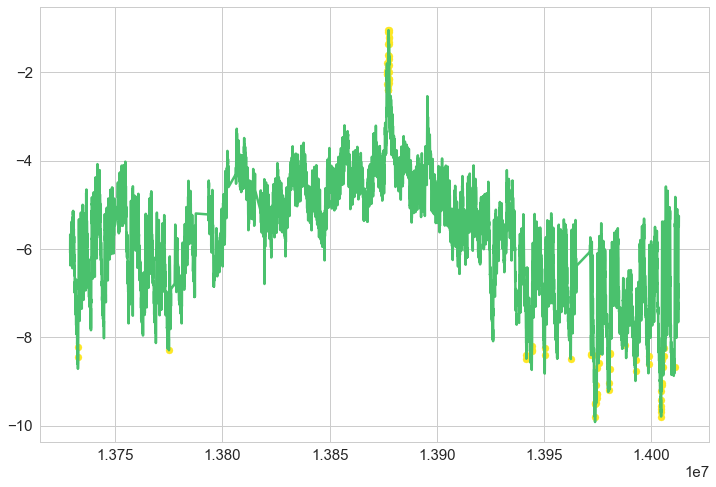

In [459]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots(figsize=(12, 8))

a = df.loc[df['anomaly22'] == 1, ('time_epoch', 'value')] #anomaly

ax.plot(df['time_epoch'], df['value'], color="#4AC16DFF")
ax.scatter(a['time_epoch'],a['value'], color="#FDE725FF")
plt.show()

/Users/nanaakwasiabayieboateng/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



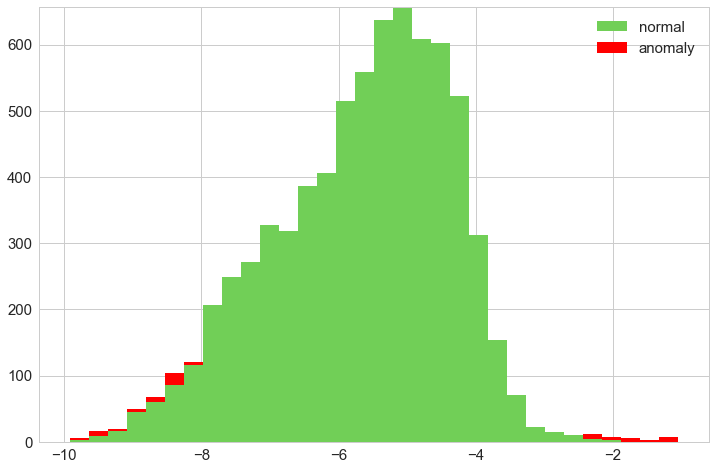

In [464]:
# visualisation of anomaly with temperature repartition (viz 2)
a = df.loc[df['anomaly22'] == 0, 'value']
b = df.loc[df['anomaly22'] == 1, 'value']

fig, axs = plt.subplots(figsize=(12, 8))
axs.hist([a,b], bins=32, stacked=True, color=["#71CF57FF", 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

####  Cluster+Gaussian
Similar to 2.2 solution but with cluster to separate data in different group.

####  Markov chains
Use for sequential anomalies (ordered)

We need to  discretize the data points in defined states for markov chain. We will just take 'value' to define state for this example and define 5 levels of value (very low, low, average, high, very high)/(VL, L, A, H, VH). Markov chain will calculate the probability of sequence like (VL, L, L, A, A, L, A). If the probability is very weak we consider the sequence as an anomaly.


In [625]:
# definition of the different state
x1 = (df['value'] <=18).astype(int)
x2= ((df['value'] > 18) & (df['value']<=21)).astype(int)
x3 = ((df['value'] > 21) & (df['value']<=24)).astype(int)
x4 = ((df['value'] > 24) & (df['value']<=27)).astype(int)
x5 = (df['value'] >27).astype(int)
df_mm = x1 + 2*x2 + 3*x3 + 4*x4 + 5*x5

# getting the anomaly labels for our dataset (evaluating sequence of 5 values and anomaly = less than 20% probable)
# I USE pyemma NOT AVAILABLE IN KAGGLE KERNEL
#df_anomaly = markovAnomaly(df_mm, 5, 0.20)
#df_anomaly = pd.Series(df_anomaly)
#print(df_anomaly.value_counts())

In [ ]:
"""
# add the data to the main 
df['anomaly24'] = df_anomaly

# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly24'] == 1, ('time_epoch', 'value')] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()
"""

In [ ]:
"""
# visualisation of anomaly with temperature repartition (viz 2)
a = df.loc[df['anomaly24'] == 0, 'value']
b = df.loc[df['anomaly24'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'])
plt.legend()
plt.show()
"""

In [537]:



filter=(df['value'] >= -4) & (df['value'] <= -2)



df2 = df[(df['value'] >= -4) & (df['value'] <= -2)][["value","WeekDay"]]
#df2[["value","WeekDay"]].head()
#df2

df[filter][['value','WeekDay']].head(2)

value  WeekDay
1800 -3.777318        1
1802 -3.863931        1

In [538]:
"""
# add the data to the main 
df['anomaly24'] = df_anomaly

# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly24'] == 1, ('time_epoch', 'value')] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()
"""

"\n# add the data to the main \ndf['anomaly24'] = df_anomaly\n\n# visualisation of anomaly throughout time (viz 1)\nfig, ax = plt.subplots()\n\na = df.loc[df['anomaly24'] == 1, ('time_epoch', 'value')] #anomaly\n\nax.plot(df['time_epoch'], df['value'], color='blue')\nax.scatter(a['time_epoch'],a['value'], color='red')\nplt.show()\n"


#### 2.5 Isolation Forest
Use for collective anomalies (unordered).
Simple, works well with different data repartition and efficient with high dimention data.

In [549]:
# Take useful feature and standardize them 
data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# train isolation forest 
model =  IsolationForest(contamination = outliers_fraction)
model.fit(data)
# add the data to the main  
df['anomaly25'] = pd.Series(model.predict(data))
df['anomaly25'] = df['anomaly25'].map( {1: 0, -1: 1} )
print(df['anomaly25'].value_counts())

0    7194
1      73
Name: anomaly25, dtype: int64


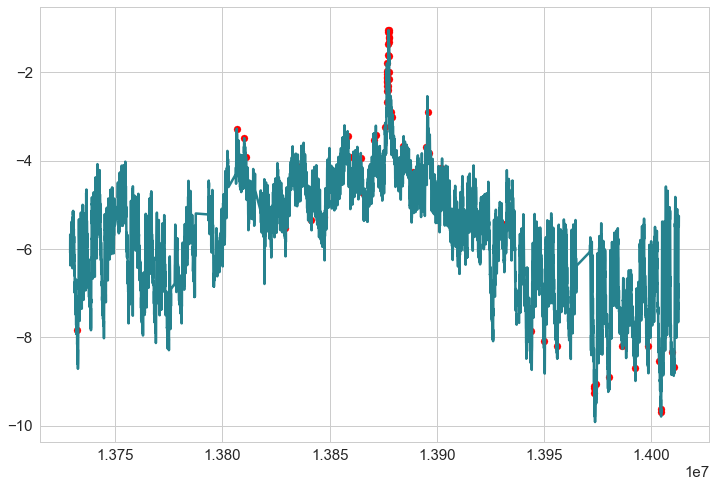

In [551]:
# visualisation of anomaly throughout time (viz 1)

fig, ax = plt.subplots(figsize=(12, 8))

a = df.loc[df['anomaly25'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color="#26828EFF")
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

/Users/nanaakwasiabayieboateng/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



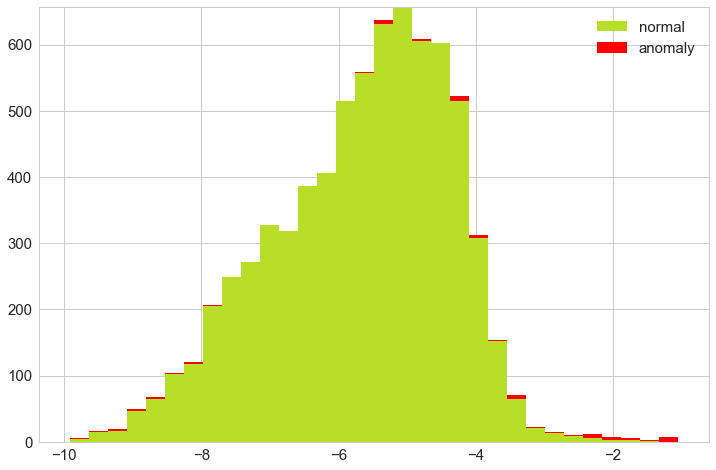

In [557]:
# visualisation of anomaly with temperature repartition (viz 2)
a = df.loc[df['anomaly25'] == 0, 'value']
b = df.loc[df['anomaly25'] == 1, 'value']

fig, axs = plt.subplots(figsize=(12, 8))

axs.hist([a,b], bins=32, stacked=True, color=["#B9DE28FF", 'red'], label = ['normal', 'anomaly'])
plt.legend()
plt.show()

#### 2.6 One class SVM
Use for collective anomalies (unordered).
Good for novelty detection (no anomalies in the train set). This algorithm performs well for multimodal data.

In [558]:
# Take useful feature and standardize them 
data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
# train one class SVM 
model =  OneClassSVM(nu=0.95 * outliers_fraction) #nu=0.95 * outliers_fraction  + 0.05
data = pd.DataFrame(np_scaled)
model.fit(data)
# add the data to the main  
df['anomaly26'] = pd.Series(model.predict(data))
df['anomaly26'] = df['anomaly26'].map( {1: 0, -1: 1} )
print(df['anomaly26'].value_counts())

0    7198
1      69
Name: anomaly26, dtype: int64


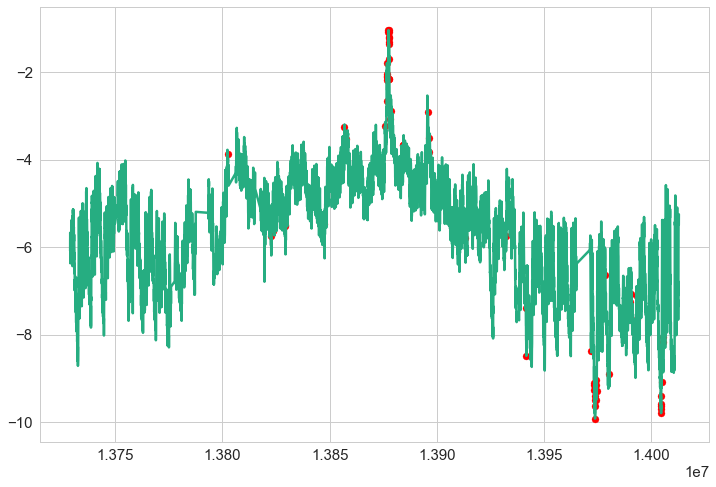

In [559]:

# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots(figsize=(12, 8))

a = df.loc[df['anomaly26'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color="#26AD81FF")
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

/Users/nanaakwasiabayieboateng/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



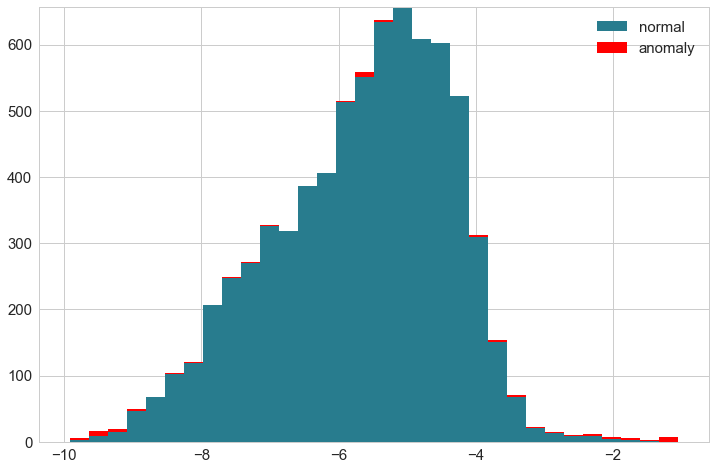

In [560]:
# visualisation of anomaly with temperature repartition (viz 2)
a = df.loc[df['anomaly26'] == 0, 'value']
b = df.loc[df['anomaly26'] == 1, 'value']
fig, axs = plt.subplots(figsize=(12, 8))
axs.hist([a,b], bins=32, stacked=True, color=["#287C8EFF", 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

#### 2.7 RNN
Use for sequential anomalies (ordered)
RNN learn to recognize sequence in the data and then make prediction based on the previous sequence. We consider an anomaly when the next data points are distant from RNN prediction. Aggregation, size of sequence and size of prediction for anomaly are important parameters to have relevant detection.
Here we make learn from 50 previous values, and we predict just the 1 next value.

In [561]:
#select and standardize data
data_n = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data_n)
data_n = pd.DataFrame(np_scaled)

# important parameters and train/test size
prediction_time = 1 
testdatasize = 1000
unroll_length = 50
testdatacut = testdatasize + unroll_length  + 1

#train data
x_train = data_n[0:-prediction_time-testdatacut].as_matrix()
y_train = data_n[prediction_time:-testdatacut  ][0].as_matrix()

# test data
x_test = data_n[0-testdatacut:-prediction_time].as_matrix()
y_test = data_n[prediction_time-testdatacut:  ][0].as_matrix()

In [568]:
#unroll: create sequence of 50 previous data points for each data points
def unroll(data,sequence_length=24):
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    return np.asarray(result)

# adapt the datasets for the sequence data shape
x_train = unroll(x_train,unroll_length)
x_test  = unroll(x_test,unroll_length)
y_train = y_train[-x_train.shape[0]:]
y_test  = y_test[-x_test.shape[0]:]

# see the shape
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (6165, 50, 5)
y_train (6165,)
x_test (1000, 50, 5)
y_test (1000,)


In [623]:
# specific libraries for RNN
# keras is a high layer build on Tensorflow layer to stay in high level/easy implementation
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import time #helper libraries
from keras.models import model_from_json
import sys

In [595]:
# Build the model
model = Sequential()

model.add(LSTM(
    input_shape=(None,x_train.shape[-1]),
    units=50,
    return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
    100,
    return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(
    units=1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop')
print('compilation time : {}'.format(time.time() - start))

compilation time : 0.03343605995178223


In [598]:
# Train the model
#

model.fit(
    x_train,
    y_train,
    batch_size=3028,
    epochs=30,
    validation_split=0.1,
verbose=0)
#verbose=0 suppresses progress bars

In [603]:
# save the model because the training is long (1h30) and we don't want to do it every time

# serialize model to JSON
model_json = model.to_json()
with open("/Users/nanaakwasiabayieboateng/PythonAnomalyDetection/model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/Users/nanaakwasiabayieboateng/PythonAnomalyDetection/model.h5")
print("Saved model to disk")



Saved model to disk


In [604]:
# load json and create model

json_file = open('/Users/nanaakwasiabayieboateng/PythonAnomalyDetection/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/Users/nanaakwasiabayieboateng/PythonAnomalyDetection/model.h5")
print("Loaded model from disk")


Loaded model from disk


In [605]:
# create the list of difference between prediction and test data
loaded_model = model
diff=[]
ratio=[]
p = loaded_model.predict(x_test)
# predictions = lstm.predict_sequences_multiple(loaded_model, x_test, 50, 50)
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))

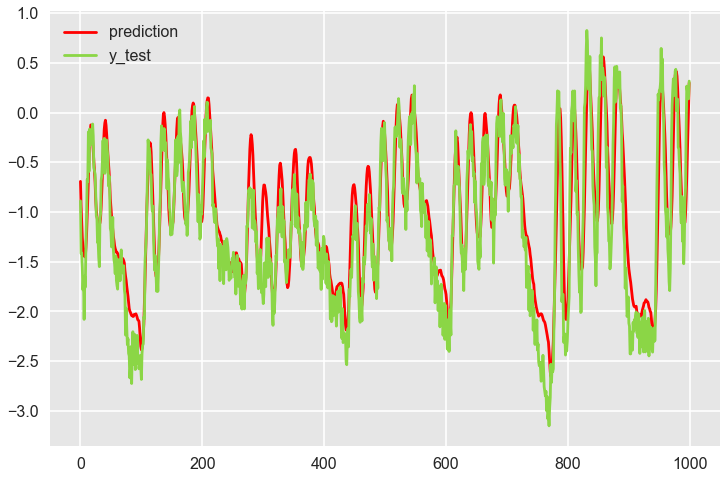

In [613]:
# plot the prediction and the reality (for the test data)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
fig, axs = plt.subplots(figsize=(12, 8))
axs.plot(p,color='red', label='prediction')
axs.plot(y_test,color="#8BD646FF", label='y_test')
plt.legend(loc='upper left')
plt.show()

In [614]:
# select the most distant prediction/reality data points as anomalies
diff = pd.Series(diff)
number_of_outliers = int(outliers_fraction*len(diff))
threshold = diff.nlargest(number_of_outliers).min()
# data with anomaly label (test data part)
test = (diff >= threshold).astype(int)
# the training data part where we didn't predict anything (overfitting possible): no anomaly
complement = pd.Series(0, index=np.arange(len(data_n)-testdatasize))
# # add the data to the main
df['anomaly27'] = complement.append(test, ignore_index='True')
print(df['anomaly27'].value_counts())

0    7257
1      10
Name: anomaly27, dtype: int64


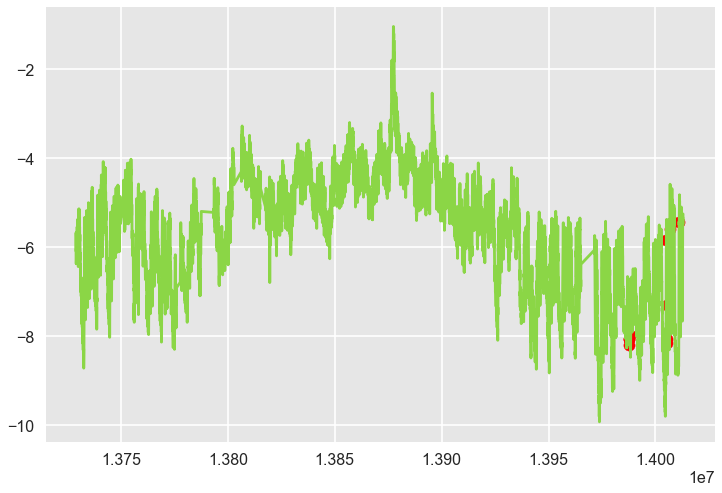

In [620]:
# visualisation of anomaly throughout time (viz 1)


a = df.loc[df['anomaly27'] == 1, ['time_epoch', 'value']] #anomaly

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(df['time_epoch'], df['value'], color="#8BD646FF")
ax.scatter(a['time_epoch'],a['value'], color='red')
#plt.axis([1.370*1e7, 1.405*1e7, 15,30])
plt.show()

/Users/nanaakwasiabayieboateng/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



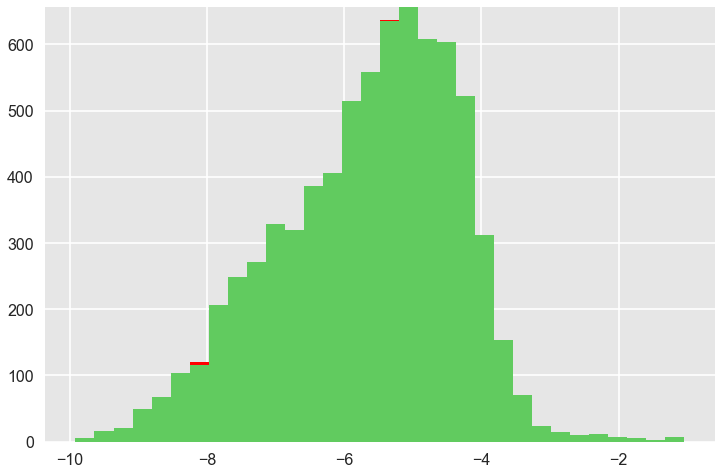

In [622]:
# visualisation of anomaly with temperature repartition (viz 2)
a = df.loc[df['anomaly27'] == 0, 'value']
b = df.loc[df['anomaly27'] == 1, 'value']

fig, axs = plt.subplots(figsize=(12, 8))
axs.hist([a,b], bins=32, stacked=True, color=["#61CB5FFF", 'red'])
plt.legend()
plt.show()